In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import get_hsm_dataset, get_solar_energy_dataset, get_fuel_prices_dataset, get_passengers_dataset, log_returns, inverse_log_returns, get_dataset_iterator
from utils.visualization import visualization

In [2]:
hsm_dataset_dir = Path("data/huge_stock_market_dataset/")
se_dataset_dir = Path("data/solar_energy/")
fp_dataset_dir = Path("data/fuel_prices/")
ap_dataset_dir = Path("data/air_passengers/")
results_dir = Path("results")

In [3]:
# def is_high_volatile(time_series, threshold=0.5, rolling_parts=200):
#     orig_std = time_series.std().values[0]
#     ma_ts = time_series.rolling(len(time_series) // rolling_parts).mean()
#     ma_std = ma_ts.std().values[0]
#     return abs(ma_std - orig_std) / orig_std# > threshold

# def ma(time_series, rolling_parts=200):
#     ts1 = time_series.rolling(len(time_series) // rolling_parts, closed="left").mean()
#     ts2 = time_series[:: - 1].rolling(len(time_series) // rolling_parts).mean()[:: - 1]
#     ts1[ts1.isna()] = ts2[ts1.isna()]
#     ts2[ts2.isna()] = ts1[ts2.isna()]
#     ats = (ts1 + ts2) / 2
#     return ats
    
# for ts in get_passengers_dataset(ap_dataset_dir):
#     print(is_high_volatile(ts, rolling_parts=200))

In [4]:
results = []
for results_type in ("real", "QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for model in ("LSTM", "TCN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if results_type == "real":
                df = pd.read_csv(results_dir / f"{results_type}_{dataset_name}_{model}.csv")
            else:
                df = pd.read_csv(results_dir / f"synth_{results_type}_{dataset_name}_{model}.csv")
            df["model"] = model
            df["results_type"] = results_type
            df["dataset"] = dataset_name
            results.append(df)
results = pd.concat(results)
results

test model   results_type dataset
0   0.352968  LSTM           real     hsm
1   0.168099  LSTM           real     hsm
2   1.425858  LSTM           real     hsm
3   0.139445  LSTM           real     hsm
4   0.283939  LSTM           real     hsm
..       ...   ...            ...     ...
45  0.650154   TCN  TimeDiffusion      ap
46  0.786622   TCN  TimeDiffusion      ap
47  1.119444   TCN  TimeDiffusion      ap
48  2.363243   TCN  TimeDiffusion      ap
49  0.731091   TCN  TimeDiffusion      ap

[2016 rows x 4 columns]

In [5]:
results_agg = results.groupby(by=["model", "results_type", "dataset"], axis=0, as_index=False).agg(test=("test", "mean"))
results_agg

model   results_type dataset      test
0   LSTM    FourierFlow      ap  0.916432
1   LSTM    FourierFlow      fp  0.384317
2   LSTM    FourierFlow     hsm  0.437786
3   LSTM    FourierFlow      se  0.257601
4   LSTM       QuantGAN      ap  0.843753
5   LSTM       QuantGAN      fp  0.900859
6   LSTM       QuantGAN     hsm  0.876942
7   LSTM       QuantGAN      se  0.620867
8   LSTM        RealNVP      ap  6.138466
9   LSTM        RealNVP      fp  0.624790
10  LSTM        RealNVP     hsm  0.587735
11  LSTM        RealNVP      se  0.075618
12  LSTM        TTS_GAN      ap  0.889776
13  LSTM        TTS_GAN      fp  0.905618
14  LSTM        TTS_GAN     hsm  0.921799
15  LSTM        TTS_GAN      se  2.094955
16  LSTM  TimeDiffusion      ap  0.890135
17  LSTM  TimeDiffusion      fp  0.311152
18  LSTM  TimeDiffusion     hsm  0.377009
19  LSTM  TimeDiffusion      se  0.488123
20  LSTM           real      ap  1.001102
21  LSTM           real      fp  0.351384
22  LSTM           real     hsm  0.434157
23  LSTM           real      se  0.203895
24   TCN    FourierFlow      ap  0.876363
25   TCN    FourierFlow      fp  0.354835
26   TCN    FourierFlow     hsm  0.306817
27   TCN    FourierFlow      se  0.206099
28   TCN       QuantGAN      ap  0.788871
29   TCN       QuantGAN      fp  0.842816
30   TCN       QuantGAN     hsm  0.812207
31   TCN       QuantGAN      se  0.687759
32   TCN        RealNVP      ap  6.347698
33   TCN        RealNVP      fp  0.608280
34   TCN        RealNVP     hsm  0.538185
35   TCN        RealNVP      se  0.076980
36   TCN        TTS_GAN      ap  0.839175
37   TCN        TTS_GAN      fp  0.846924
38   TCN        TTS_GAN     hsm  0.844836
39   TCN        TTS_GAN      se  2.101960
40   TCN  TimeDiffusion      ap  0.827967
41   TCN  TimeDiffusion      fp  0.273931
42   TCN  TimeDiffusion     hsm  0.256812
43   TCN  TimeDiffusion      se  0.221928
44   TCN           real      ap  0.900743
45   TCN           real      fp  0.332396
46   TCN           real     hsm  0.285660
47   TCN           real      se  0.136869

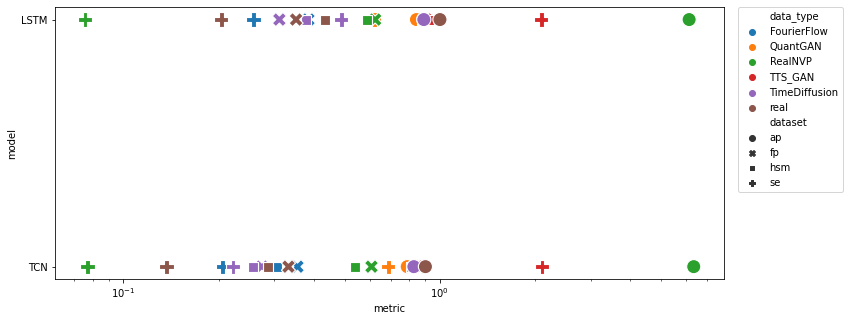

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(x=results_agg["test"].rename("metric"), y=results_agg["model"], 
    hue=results_agg["results_type"].rename("data_type"), style=results_agg["dataset"], s=200, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xscale("log")
plt.show()

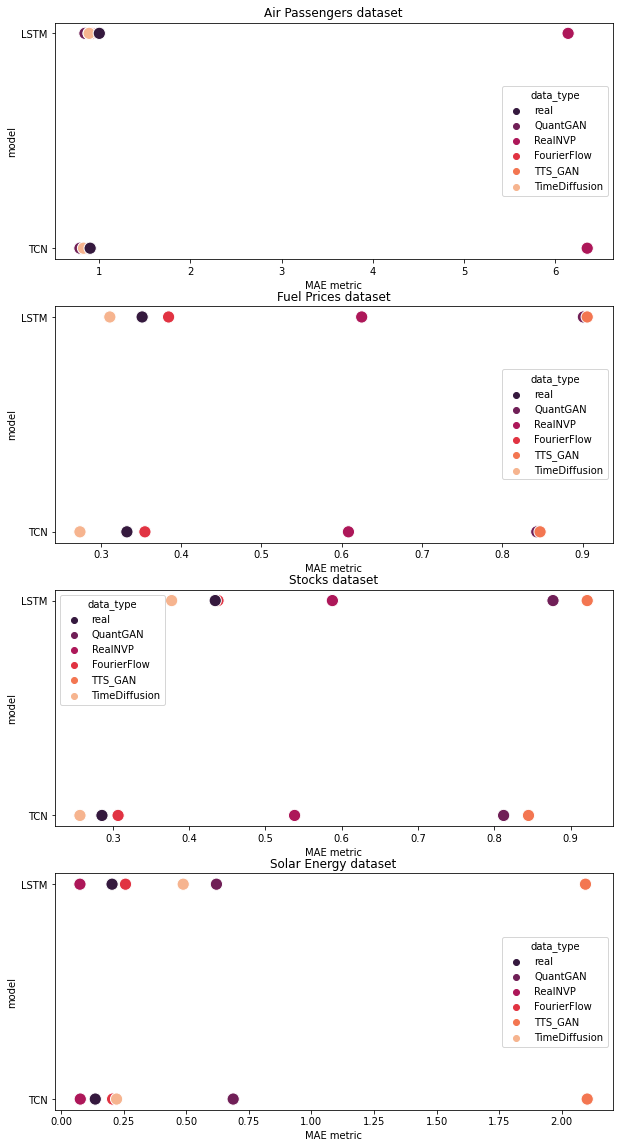

In [7]:
fig, axs = plt.subplots(4, figsize=(10, 20))
for i, dataset_name in enumerate(results_agg.dataset.unique()):
    loc_res = results_agg[results_agg.dataset == dataset_name]
    sns.scatterplot(x=loc_res["test"].rename("MAE metric"), y=loc_res["model"], hue=loc_res["results_type"].rename("data_type"),
     hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion"), ax=axs[i], s=150, palette="rocket")
    axs[i].set_title({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}[dataset_name] + " dataset")

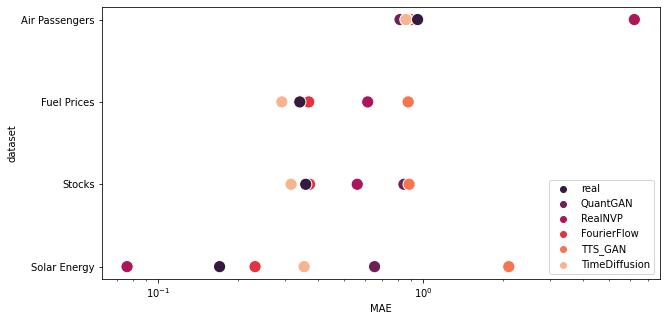

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
advanced_results_agg = results_agg.groupby(["dataset", "results_type"], as_index=False).agg(MAE=("test", "mean"))
sns.scatterplot(data=advanced_results_agg, x="MAE", y=advanced_results_agg["dataset"]\
    .replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
    hue="results_type",\
    hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion"), ax=ax, s=150, palette="rocket")
ax.legend(bbox_to_anchor=(0.99, 0.02), loc='lower right', borderaxespad=0)
plt.xscale("log")
plt.show()

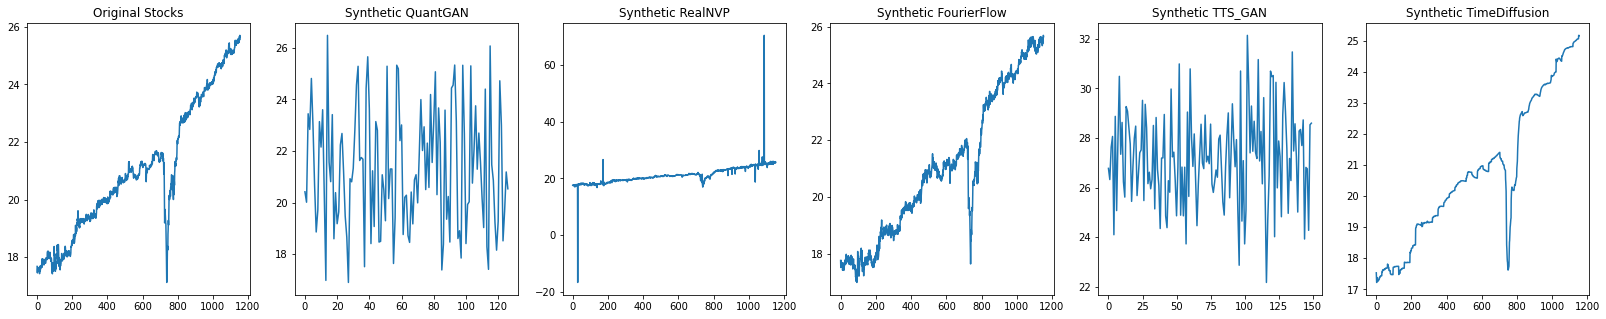

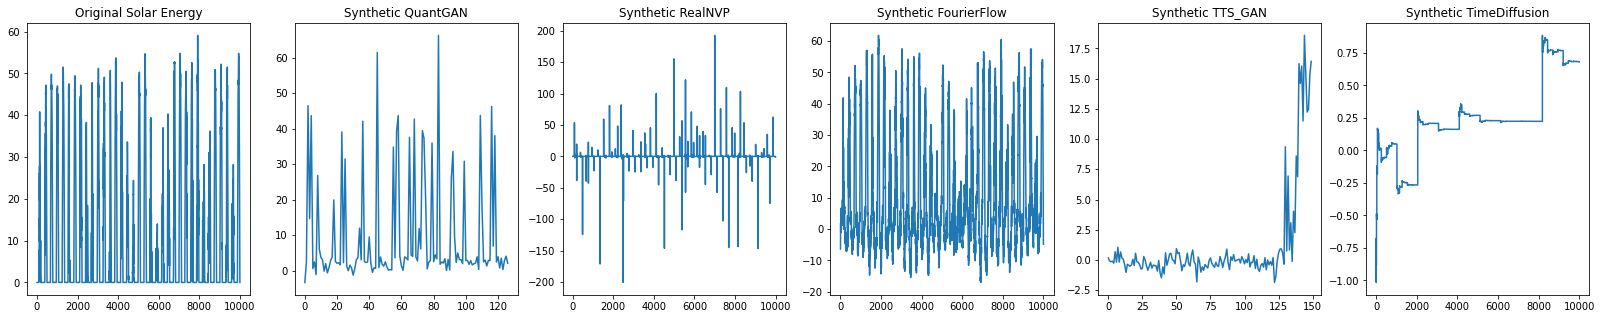

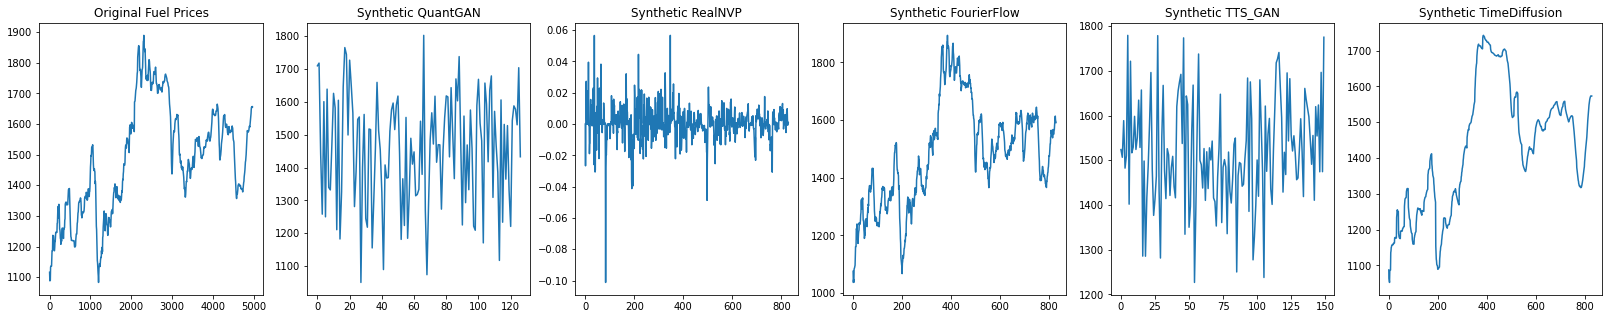

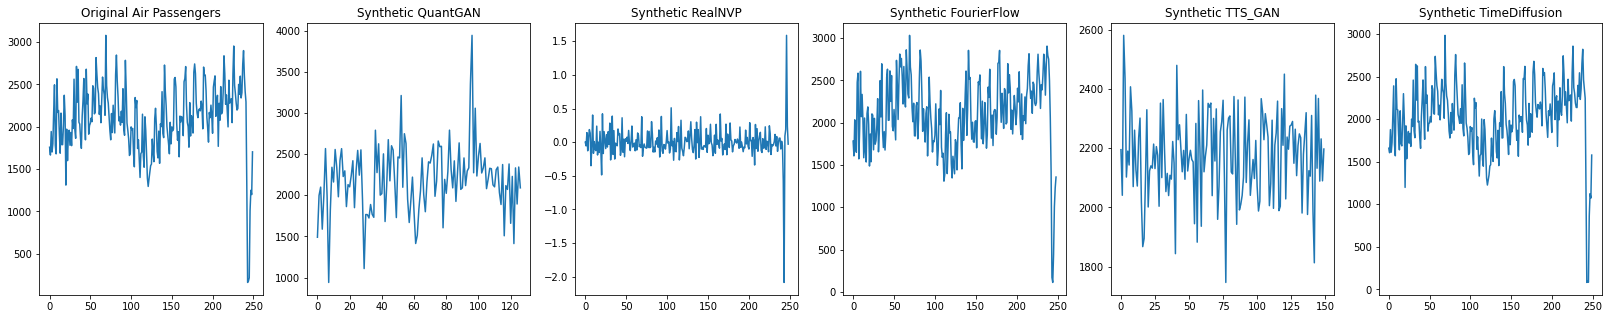

In [9]:
for dataset_name, dataset_dir, dataset_func in (
    ("Stocks", hsm_dataset_dir, get_hsm_dataset),
    ("Solar Energy", se_dataset_dir, get_solar_energy_dataset),
    ("Fuel Prices", fp_dataset_dir, get_fuel_prices_dataset),
    ("Air Passengers", ap_dataset_dir, get_passengers_dataset),    
):
    if dataset_name == "Stocks":
        time_series = next(dataset_func(dataset_dir, dataset_dir / "selected100.csv"))
    else:
        time_series = next(dataset_func(dataset_dir))

    fig, axs = plt.subplots(1, 6, figsize=(28, 5))
    axs[0].plot(time_series)
    axs[0].set_title(f"Original {dataset_name}")
    # axs[0].get_xaxis().set_visible(False)
    # axs[0].get_yaxis().set_visible(False)
    for i, model_name in zip(range(1, 6), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion")):
        synth_time_series = np.load(dataset_dir / f"synthetic/{model_name}/selected0.npy")
        axs[i].plot(synth_time_series[- 1].flatten())
        axs[i].set_title(f"Synthetic {model_name}")
        # axs[i].get_xaxis().set_visible(False)
        # axs[i].get_yaxis().set_visible(False)
plt.show()

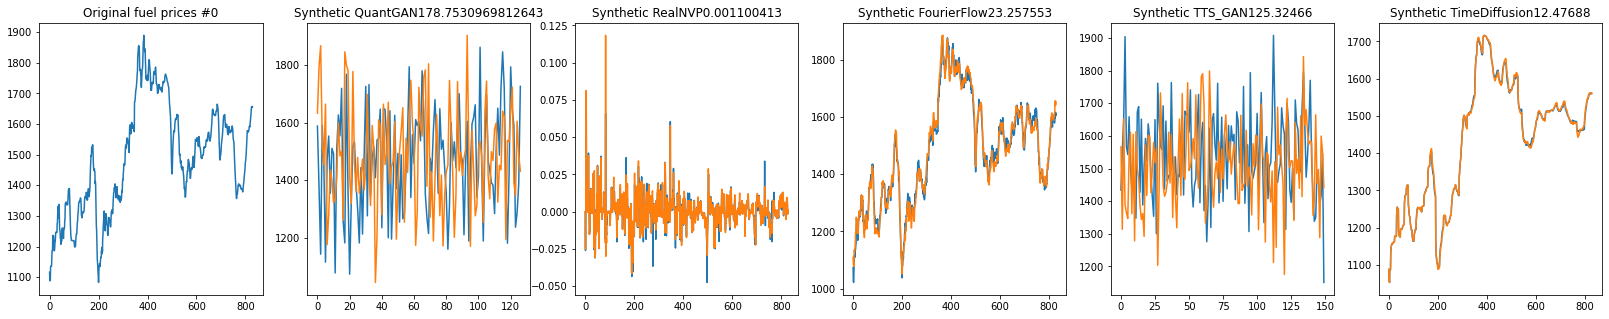

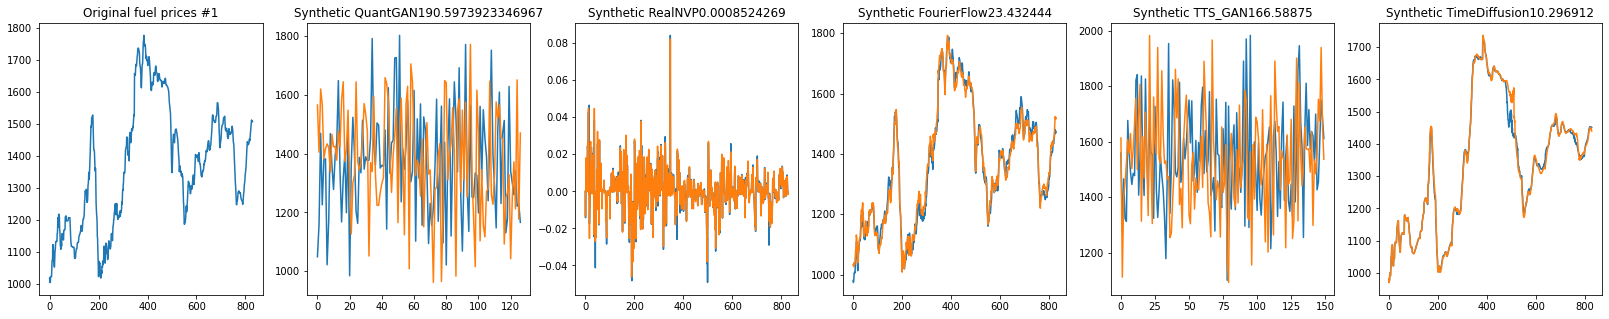

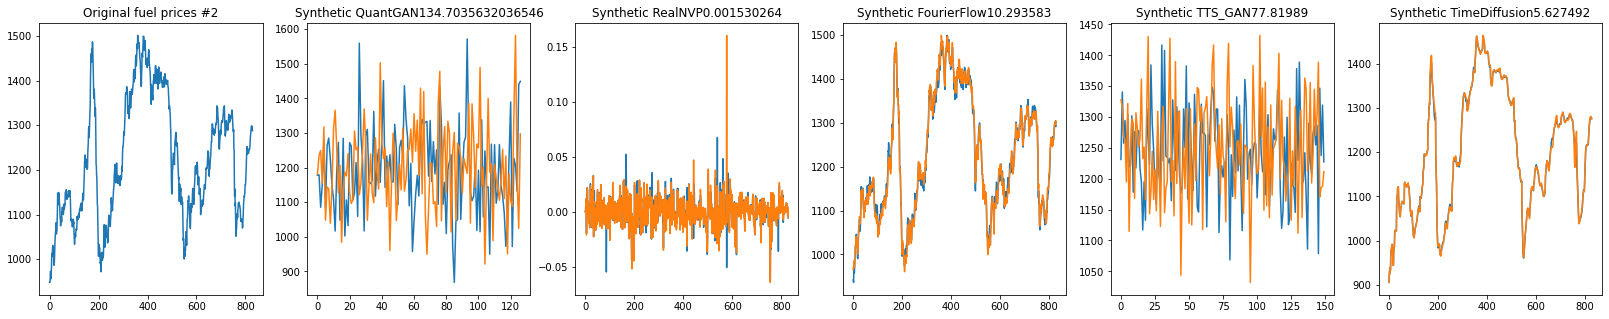

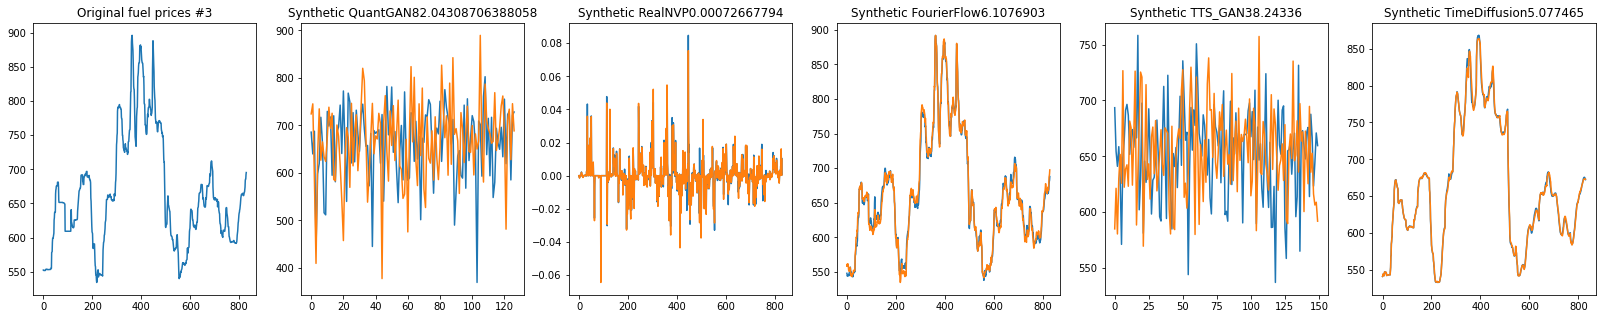

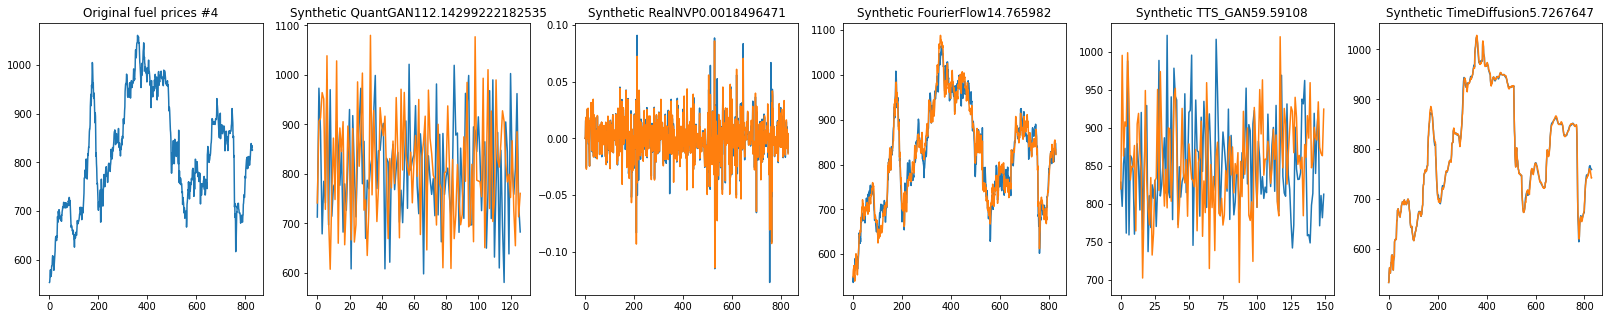

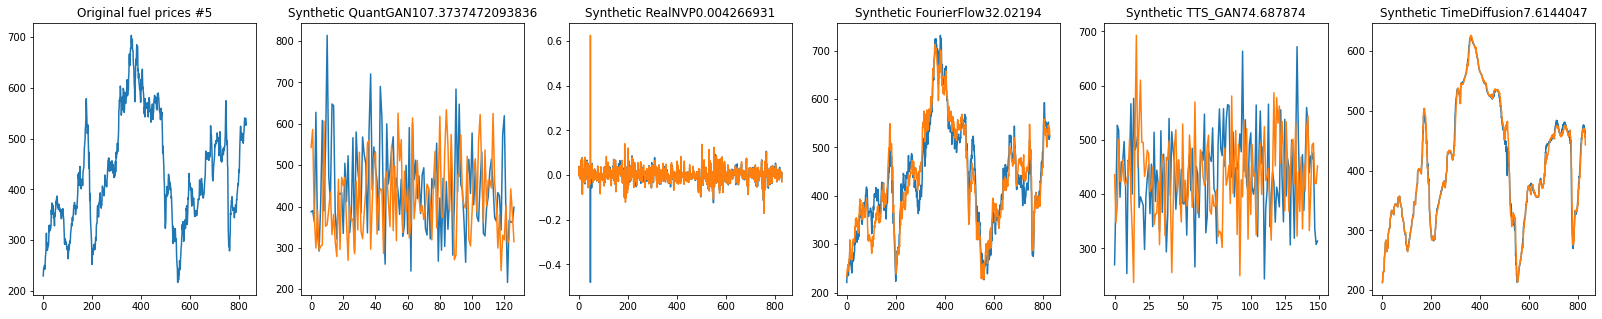

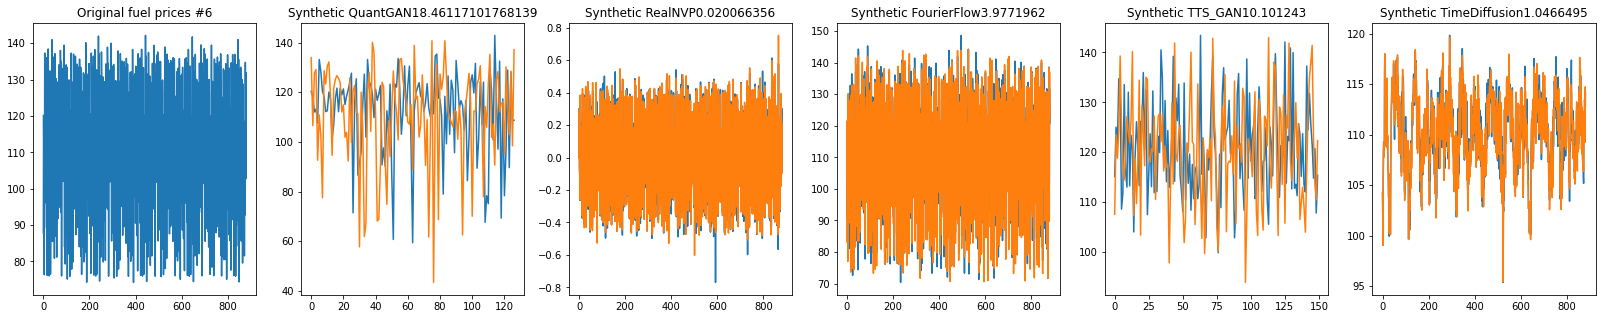

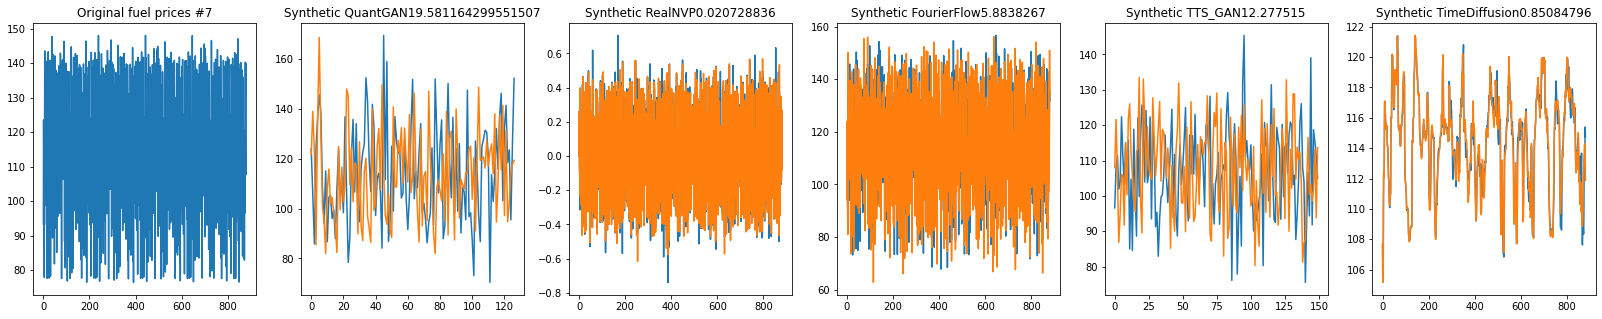

In [10]:
ts_iterator = get_fuel_prices_dataset(fp_dataset_dir)

for ts_index, time_series in enumerate(ts_iterator):
    fig, axs = plt.subplots(1, 6, figsize=(28, 5))
    axs[0].plot(time_series.values.flatten())
    axs[0].set_title(f"Original fuel prices #{ts_index}")
    # axs[0].get_xaxis().set_visible(False)
    # axs[0].get_yaxis().set_visible(False)
    for i, model_name in zip(range(1, 6), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion")):
        synth_time_series = np.load(fp_dataset_dir / f"synthetic/{model_name}/selected{ts_index}.npy")
        axs[i].plot(synth_time_series[0].flatten())
        axs[i].plot(synth_time_series[1].flatten())
        axs[i].set_title(f"Synthetic {model_name}" + str(synth_time_series.std(axis=0).mean()))
        # axs[i].get_xaxis().set_visible(False)
        # axs[i].get_yaxis().set_visible(False)
plt.show()

# Synthetic similarity results

In [11]:
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}

In [12]:
results = []
for model in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for dataset_name in ("hsm", "se", "fp", "ap"):
        df = pd.read_csv(results_dir / f"synth_{dataset_name}_sim_{model}.csv")[:ds_lens[dataset_name]]
        results.append({"model": model, "dataset": dataset_name,
        "js_div": df["js_div"].mean(), "kstest_pass": (df["kstest_pval"] > 0.05).mean()})
synth_sim_results = pd.DataFrame(results)
synth_sim_results

model dataset    js_div  kstest_pass
0        QuantGAN     hsm  0.037181        0.010
1        QuantGAN      se  0.083084        0.000
2        QuantGAN      fp  0.037501        0.250
3        QuantGAN      ap  0.036218        0.460
4         TTS_GAN     hsm  0.033195        0.010
5         TTS_GAN      se  0.089325        0.000
6         TTS_GAN      fp  0.034081        0.000
7         TTS_GAN      ap  0.034563        0.140
8         RealNVP     hsm  0.038652        0.980
9         RealNVP      se  0.118025        0.000
10        RealNVP      fp  0.021295        0.000
11        RealNVP      ap  0.043846        0.000
12    FourierFlow     hsm  0.000996        0.730
13    FourierFlow      se  0.048093        0.000
14    FourierFlow      fp  0.001337        1.000
15    FourierFlow      ap  0.003483        0.980
16  TimeDiffusion     hsm  0.001028        0.000
17  TimeDiffusion      se  0.160113        0.000
18  TimeDiffusion      fp  0.007916        0.125
19  TimeDiffusion      ap  0.005479        0.300

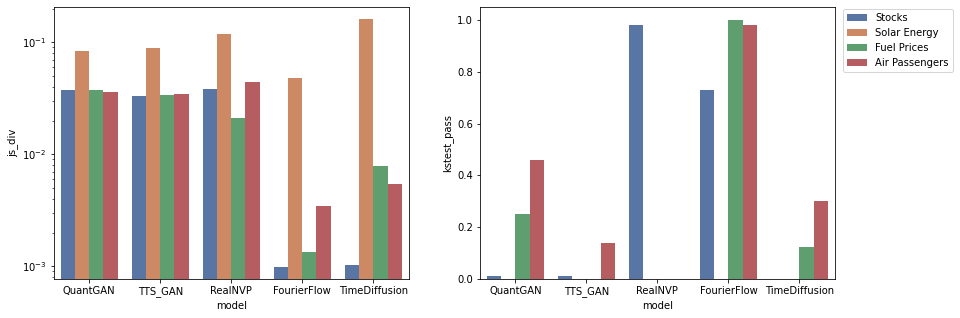

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric_name in enumerate(("js_div", "kstest_pass")):
    if metric_name == "kstest_pval":
        synth_sim_results
    sns.barplot(x=synth_sim_results["model"], y=synth_sim_results[metric_name], 
        hue=synth_sim_results["dataset"].replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
             ax=axs[i], palette="deep")
axs[0].set_yscale("log")
axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.01, 1.01))
# axs[1].plot(axs[1].get_xbound(), [0.05] * 2, "k--")
plt.show()

In [14]:
dfs = {}
for res_type in ("real", "QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for model in ("LSTM", "TCN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if res_type == "real":
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"{res_type}_{dataset_name}_{model}.csv")["test"]
            else:
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"synth_{res_type}_{dataset_name}_{model}.csv")["test"]
results = pd.DataFrame(dfs)
results

real_LSTM_hsm  real_LSTM_se  real_LSTM_fp  real_LSTM_ap  real_TCN_hsm  \
0        0.352968      0.184991      0.202559      0.795698      0.260205   
1        0.168099      0.209926      0.143776      0.625052      0.152844   
2        1.425858      0.204776      0.268309      0.082674      0.939176   
3        0.139445      0.301617      0.164236      0.464227      0.068642   
4        0.283939      0.181014      0.229799      0.884233      0.137041   
..            ...           ...           ...           ...           ...   
95       0.311294           NaN           NaN           NaN      0.252606   
96       0.228035           NaN           NaN           NaN      0.247496   
97       0.502270           NaN           NaN           NaN      0.060227   
98       1.980303           NaN           NaN           NaN      0.266872   
99       0.645744           NaN           NaN           NaN      0.404674   

    real_TCN_se  real_TCN_fp  real_TCN_ap  QuantGAN_LSTM_hsm  \
0      0.147378     0.166383     0.723236           0.899521   
1      0.153060     0.156278     0.601431           0.818553   
2      0.128122     0.208905     0.080697           0.858767   
3      0.144217     0.138380     0.504273           0.857949   
4      0.123609     0.233753     0.944198           0.940779   
..          ...          ...          ...                ...   
95          NaN          NaN          NaN           1.005319   
96          NaN          NaN          NaN           0.964678   
97          NaN          NaN          NaN           0.897746   
98          NaN          NaN          NaN           0.928570   
99          NaN          NaN          NaN           0.720817   

    QuantGAN_LSTM_se  ...  FourierFlow_TCN_fp  FourierFlow_TCN_ap  \
0           0.706835  ...            0.202846            0.711581   
1           0.537630  ...            0.168418            0.628996   
2           0.588581  ...            0.216392            0.277708   
3           0.528353  ...            0.173286            0.499886   
4           0.676293  ...            0.244187            1.016143   
..               ...  ...                 ...                 ...   
95               NaN  ...                 NaN                 NaN   
96               NaN  ...                 NaN                 NaN   
97               NaN  ...                 NaN                 NaN   
98               NaN  ...                 NaN                 NaN   
99               NaN  ...                 NaN                 NaN   

    TimeDiffusion_LSTM_hsm  TimeDiffusion_LSTM_se  TimeDiffusion_LSTM_fp  \
0                 0.231638               0.587299               0.128603   
1                 0.135717               0.142059               0.135676   
2                 1.187328               0.073960               0.235294   
3                 0.091193               1.645614               0.187444   
4                 0.362482               0.142899               0.200696   
..                     ...                    ...                    ...   
95                0.182589                    NaN                    NaN   
96                0.286388                    NaN                    NaN   
97                0.178901                    NaN                    NaN   
98                1.517428                    NaN                    NaN   
99                0.467041                    NaN                    NaN   

    TimeDiffusion_LSTM_ap  TimeDiffusion_TCN_hsm  TimeDiffusion_TCN_se  \
0                0.726767               0.162253              0.296764   
1                0.428658               0.099733              0.157475   
2                0.100925               0.843008              0.214239   
3                0.381673               0.066569              0.459242   
4                0.724619               0.150311              0.075176   
..                    ...                    ...                   ...   
95                    NaN               0.170941  

In [15]:
corrs = []
for model in ("LSTM", "TCN"):
    for res_type in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # correlation
            res = np.corrcoef([results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]],
                results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]]])[0][1]
            z = 0.5 * np.log((1 + res) / (1 - res))
            SE =  1 / (ds_lens[dataset_name] - 3) ** 0.5
            zl, zh = z - 1.96 * SE, z + 1.96 * SE
            lb, hb = ((np.e ** (2 * zl) - 1) / (np.e ** (2 * zl) + 1), (np.e ** (2 * zh) - 1) / (np.e ** (2 * zh) + 1))
            corrs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "correlation": res,\
                "low_bound": lb, "high_bound": hb})
corrs = pd.DataFrame(corrs)
corrs

model    synth_model dataset  correlation  low_bound  high_bound
0   LSTM       QuantGAN     hsm     0.069925  -0.128258    0.262738
1   LSTM       QuantGAN      se    -0.437873  -0.836802    0.264754
2   LSTM       QuantGAN      fp    -0.398002  -0.861159    0.426218
3   LSTM       QuantGAN      ap    -0.125052  -0.389835    0.158829
4   LSTM        TTS_GAN     hsm    -0.071949  -0.264630    0.126257
5   LSTM        TTS_GAN      se     0.541428  -0.133829    0.873340
6   LSTM        TTS_GAN      fp    -0.318438  -0.835610    0.497991
7   LSTM        TTS_GAN      ap    -0.109112  -0.376044    0.174541
8   LSTM        RealNVP     hsm     0.739821   0.635791    0.817453
9   LSTM        RealNVP      se     0.518031  -0.165626    0.865398
10  LSTM        RealNVP      fp     0.787951   0.187230    0.959735
11  LSTM        RealNVP      ap     0.164059  -0.119763    0.423091
12  LSTM    FourierFlow     hsm     0.873413   0.817185    0.913173
13  LSTM    FourierFlow      se     0.089841  -0.572159    0.680956
14  LSTM    FourierFlow      fp     0.996899   0.982234    0.999462
15  LSTM    FourierFlow      ap     0.858955   0.763040    0.917856
16  LSTM  TimeDiffusion     hsm     0.944948   0.919124    0.962687
17  LSTM  TimeDiffusion      se     0.693378   0.113135    0.920949
18  LSTM  TimeDiffusion      fp     0.994002   0.965863    0.998958
19  LSTM  TimeDiffusion      ap     0.927162   0.874499    0.958220
20   TCN       QuantGAN     hsm     0.044574  -0.153189    0.238904
21   TCN       QuantGAN      se    -0.163944  -0.719326    0.519295
22   TCN       QuantGAN      fp    -0.575938  -0.910920    0.216685
23   TCN       QuantGAN      ap    -0.177959  -0.434775    0.105625
24   TCN        TTS_GAN     hsm    -0.095797  -0.286822    0.102554
25   TCN        TTS_GAN      se     0.485047  -0.208160    0.853899
26   TCN        TTS_GAN      fp     0.005278  -0.702014    0.707328
27   TCN        TTS_GAN      ap    -0.151419  -0.412390    0.132519
28   TCN        RealNVP     hsm     0.533367   0.376377    0.660583
29   TCN        RealNVP      se     0.215486  -0.479160    0.744155
30   TCN        RealNVP      fp     0.807413   0.238340    0.963750
31   TCN        RealNVP      ap     0.166703  -0.117082    0.425320
32   TCN    FourierFlow     hsm     0.973993   0.961524    0.982458
33   TCN    FourierFlow      se     0.459245  -0.239701    0.844645
34   TCN    FourierFlow      fp     0.998401   0.990806    0.999723
35   TCN    FourierFlow      ap     0.892119   0.816531    0.937635
36   TCN  TimeDiffusion     hsm     0.971126   0.957312    0.980515
37   TCN  TimeDiffusion      se     0.220059  -0.475452    0.746290
38   TCN  TimeDiffusion      fp     0.996392   0.979352    0.999374
39   TCN  TimeDiffusion      ap     0.879734   0.796401    0.930282

In [16]:
corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()
corrs_agg

C:\Users\Владислав\AppData\Local\Temp/ipykernel_8332/2987291452.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()


dataset    synth_model  correlation  low_bound  high_bound
0       ap    FourierFlow     0.875537   0.789785    0.927745
1       ap       QuantGAN    -0.151506  -0.412305    0.132227
2       ap        RealNVP     0.165381  -0.118422    0.424205
3       ap        TTS_GAN    -0.130265  -0.394217    0.153530
4       ap  TimeDiffusion     0.903448   0.835450    0.944251
5       fp    FourierFlow     0.997650   0.986520    0.999592
6       fp       QuantGAN    -0.486970  -0.886039    0.321451
7       fp        RealNVP     0.797682   0.212785    0.961743
8       fp        TTS_GAN    -0.156580  -0.768812    0.602659
9       fp  TimeDiffusion     0.995197   0.972608    0.999166
10     hsm    FourierFlow     0.923703   0.889354    0.947815
11     hsm       QuantGAN     0.057250  -0.140724    0.250821
12     hsm        RealNVP     0.636594   0.506084    0.739018
13     hsm        TTS_GAN    -0.083873  -0.275726    0.114406
14     hsm  TimeDiffusion     0.958037   0.938218    0.971601
15      se    FourierFlow     0.274543  -0.405930    0.762800
16      se       QuantGAN    -0.300909  -0.778064    0.392024
17      se        RealNVP     0.366758  -0.322393    0.804777
18      se        TTS_GAN     0.513237  -0.170995    0.863619
19      se  TimeDiffusion     0.456718  -0.181159    0.833620

<AxesSubplot:xlabel='synth_model', ylabel='correlation'>

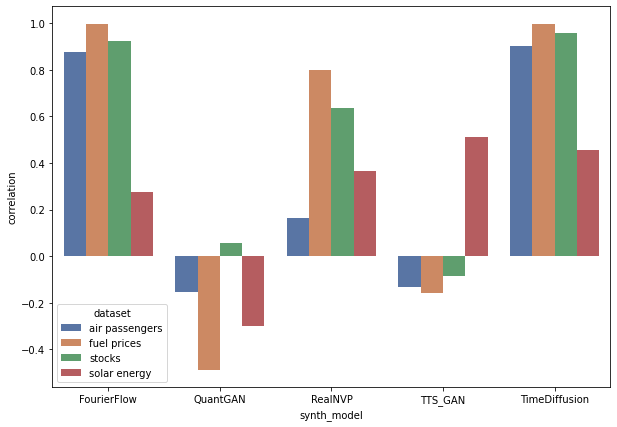

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=corrs_agg["synth_model"], y=corrs_agg["correlation"],\
    hue=corrs_agg["dataset"].replace({"se": "solar energy", "hsm": "stocks", "fp": "fuel prices", "ap": "air passengers"}), \
        ax=ax, palette="deep")

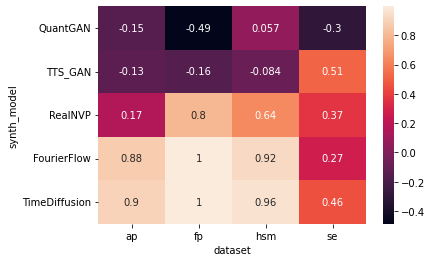

In [18]:
sns.heatmap(
    corrs_agg.pivot_table(index="synth_model", columns="dataset", values="correlation", aggfunc=np.mean).sort_values("ap"),
    annot=True
)
plt.show()

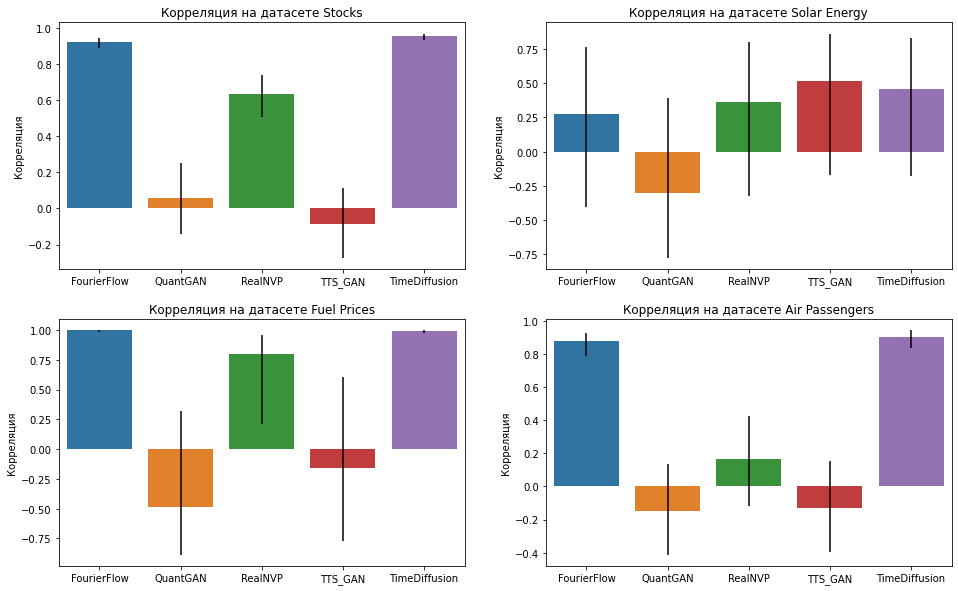

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, dsname in enumerate(("hsm", "se", "fp", "ap")):
    loc_data = corrs_agg[corrs_agg.dataset == dsname]
    sns.barplot(data=loc_data, x="synth_model", y="correlation",\
        yerr=(loc_data["correlation"] - loc_data["low_bound"], loc_data["high_bound"] - loc_data["correlation"]), ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title("Корреляция на датасете " + {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}[dsname])
    axs[i // 2][i % 2].set_xlabel("")
    axs[i // 2][i % 2].set_ylabel("Корреляция")

Deviation

In [20]:
devs = []  # deviation
for model in ("LSTM", "TCN"):
    for res_type in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # deviation
            dev = np.mean(np.abs(results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]] /\
                results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]] - 1)) * 100
            devs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "deviation": dev,})
devs = pd.DataFrame(devs)
devs

model    synth_model dataset    deviation
0   LSTM       QuantGAN     hsm   330.209970
1   LSTM       QuantGAN      se   212.854479
2   LSTM       QuantGAN      fp   265.912175
3   LSTM       QuantGAN      ap    51.917864
4   LSTM        TTS_GAN     hsm   373.759342
5   LSTM        TTS_GAN      se   924.843099
6   LSTM        TTS_GAN      fp   266.651272
7   LSTM        TTS_GAN      ap    55.266286
8   LSTM        RealNVP     hsm    53.855794
9   LSTM        RealNVP      se    62.479944
10  LSTM        RealNVP      fp   123.198493
11  LSTM        RealNVP      ap   535.738718
12  LSTM    FourierFlow     hsm    35.479163
13  LSTM    FourierFlow      se    32.080489
14  LSTM    FourierFlow      fp    13.693854
15  LSTM    FourierFlow      ap    23.542023
16  LSTM  TimeDiffusion     hsm    28.267501
17  LSTM  TimeDiffusion      se   156.818795
18  LSTM  TimeDiffusion      fp    14.636172
19  LSTM  TimeDiffusion      ap    18.708190
20   TCN       QuantGAN     hsm   432.489504
21   TCN       QuantGAN      se   405.230586
22   TCN       QuantGAN      fp   275.489741
23   TCN       QuantGAN      ap    50.238437
24   TCN        TTS_GAN     hsm   477.492863
25   TCN        TTS_GAN      se  1426.769996
26   TCN        TTS_GAN      fp   271.933454
27   TCN        TTS_GAN      ap    52.716575
28   TCN        RealNVP     hsm   112.396811
29   TCN        RealNVP      se    43.611400
30   TCN        RealNVP      fp   136.375140
31   TCN        RealNVP      ap   585.859554
32   TCN    FourierFlow     hsm    31.848490
33   TCN    FourierFlow      se    50.737903
34   TCN    FourierFlow      fp     9.527053
35   TCN    FourierFlow      ap    17.478439
36   TCN  TimeDiffusion     hsm    26.352440
37   TCN  TimeDiffusion      se    80.965359
38   TCN  TimeDiffusion      fp    18.599068
39   TCN  TimeDiffusion      ap    16.544010

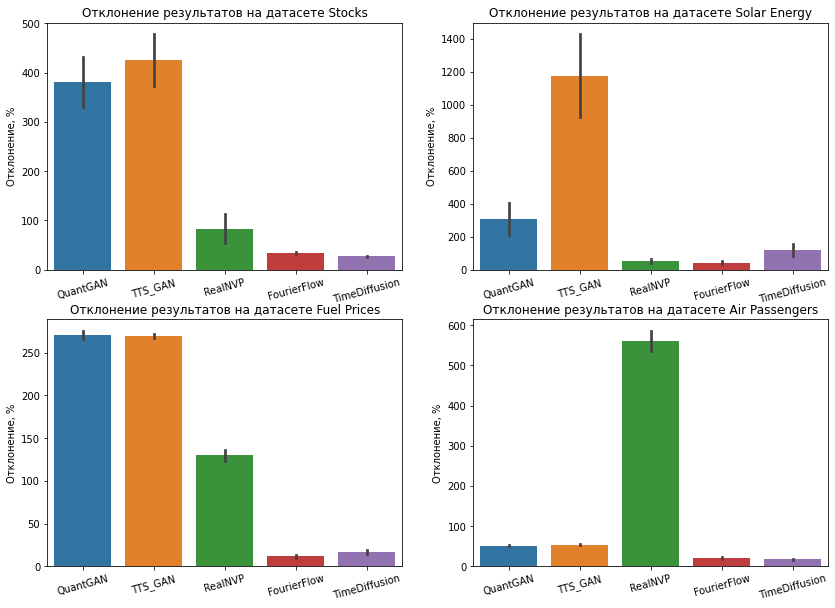

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ds_name_extension = {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}
for i, dataset in enumerate(("hsm", "se", "fp", "ap")):
    sns.barplot(data=devs[devs.dataset == dataset], x="synth_model", y="deviation", ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title(f"Отклонение результатов на датасете {ds_name_extension[dataset]}")
    axs[i // 2][i % 2].set_ylabel("Отклонение, %")
    axs[i // 2][i % 2].set_xlabel("")
    axs[i // 2][i % 2].set_xticklabels(axs[i // 2][i % 2].get_xticklabels(), rotation=15)